<a href="https://colab.research.google.com/github/sumanapalle065/LC25000-Hybrid-Architecture-using-DL/blob/main/mobilenetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
 #!unzip "/content/drive/MyDrive/LC25000.zip"

In [3]:

import cv2
import numpy as np
import os
import glob #for searching based on filename patterns which is generally used to get file paths
import matplotlib.pyplot as matplotlib
import random
import tqdm

from PIL import Image, ImageEnhance

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, InceptionV3, EfficientNetB7
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Input, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import precision_score, recall_score, f1_score

import seaborn as sns

from sklearn.metrics import precision_recall_curve, confusion_matrix, average_precision_score

from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from keras.models import load_model
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [4]:
#load lung_colon_image_dataset
lung_colon_image_dataset=glob.glob("/content/lung_colon_image_set/*/*/*")
lung_colon_image_dataset

['/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca4075.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca893.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca4928.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca4813.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca2802.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca2872.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca3930.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca4870.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca2166.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca4825.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca853.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca1996.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca

In [5]:
len(lung_colon_image_dataset)

25000

In [6]:
from tqdm import tqdm
# Initialize an empty list 'processed_images' to store the processed image data
processed_images = []
# Initialize an empty list 'labels' to hold the corresponding labels of the images
labels = []
# Define a class dictionary called 'label_map' that maps specific class names
label_map = {
    "lung_aca": 0,
    "colon_n": 1,
    "lung_n": 2,
    "lung_scc": 3,
    "colon_aca": 4,
}
# Iterate over the list of path to each image  with a progress bar
for img_path in tqdm(lung_colon_image_dataset):
  # Reading the image from the current path using imread function of OpenCV
    img = cv2.imread(img_path)
    # If the image has failed to load properly, in other words it is None, skip the iteration and move to the next image
    if img is None:
      # Resize image to 148x148 pixels to standardize the size of input
        continue
    img = cv2.resize(img, (148, 148))
 # To blur the resized image by applying  kernel to remove noise in the image and blur.
    blurred_img = cv2.GaussianBlur(img, (5, 5), 0)

# Convert the blurry image to LAB color space-for better illumination handling
    lab = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2LAB)
    # Split the LAB image into channels L, A and B
    l, a, b = cv2.split(lab)
    # Create a CLAHE object with some clip limit, tile grid size
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # Applying CLAHE on the L channel (luminance) for contrast enhancement
    cl = clahe.apply(l)
    # Merging enhanced CLAHE L channel with original A and B channels
    lab_clahe = cv2.merge((cl, a, b))
    # Convert the LAB image back to BGR color space after CLAHE application
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)
    # Convert CLAHE-enhanced image to grayscale for thresholding and contour detection
    gray = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2GRAY)
    # Use OpenCV's Otsu's thresholding to the grayscale image to get a black and white image with inverted colors
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Find contours of the object on the thresholded image using OpenCV's findContours function to detect boundaries and outlines
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Create a mask of zeros filled with black for overlay onto the contours
    mask = np.zeros_like(img)
    # Detect contours in mask, draw them on it with green color, thickness of 2
    cv2.drawContours(mask, contours, -1, (0, 255, 0), 2)
    # Apply mask to the original image using bitwise AND to segment region of interest
    segmented_image = cv2.bitwise_and(img, mask)
    # Convert image from BGR to RGB for appropriate visualisation
    segmented_image_rgb = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)
 # Normalize the segmented image by converting its pixel values to float32 and scaling them to the range
    normalized_img = segmented_image_rgb.astype(np.float32) / 255.0
    # Append normalized image to 'processed_images
    processed_images.append(normalized_img)
    # Extract the class name from the parent directory of the image path that will be assumed as a label
    label = img_path.split(os.path.sep)[-2]
    # Check whether the extracted label is in 'label_map' dictionary or not
    if label in label_map:
      # If label is in 'label_map', append the numeric label corresponding to that one to the 'labels' list
        labels.append(label_map[label])

100%|██████████| 25000/25000 [02:08<00:00, 194.27it/s]


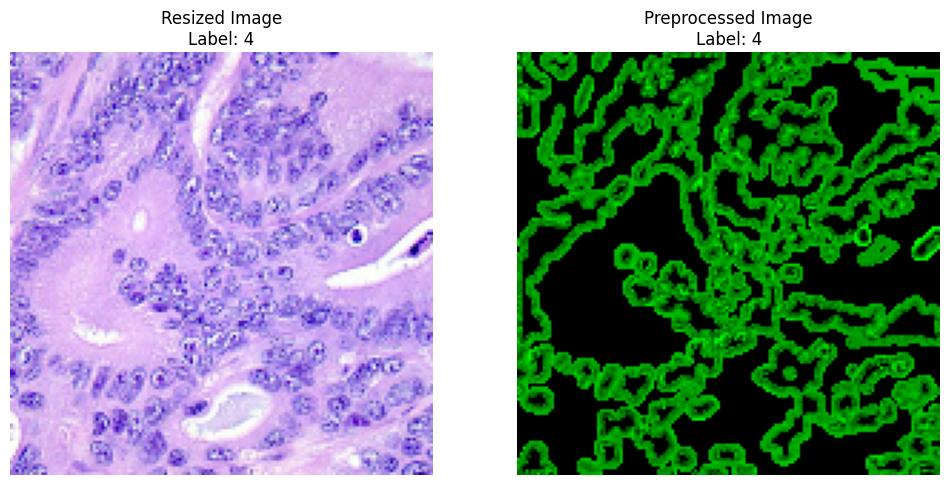

In [7]:
import random
import matplotlib.pyplot as plt

# Select a random image index from the processed images
random_index = random.randint(0, len(processed_images) - 1)

# Get the corresponding original image and its preprocessed version
random_image_path = lung_colon_image_dataset[random_index]  # Get the path of the random image
original_image = cv2.imread(random_image_path)  # Read the original image

# Resize the original image (simulating the same resize step as in preprocessing)
resized_image = cv2.resize(original_image, (148, 148))

# Get the preprocessed (segmented) image and its label
preprocessed_image = processed_images[random_index]
label = labels[random_index]

# Plot the original resized image and preprocessed image side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the resized image on the first subplot
axes[0].imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for visualization
axes[0].set_title(f"Resized Image\nLabel: {label}")
axes[0].axis('off')  # Hide axes for the resized image

# Display the preprocessed image (segmented image) on the second subplot
axes[1].imshow(preprocessed_image)
axes[1].set_title(f"Preprocessed Image\nLabel: {label}")
axes[1].axis('off')  # Hide axes for the preprocessed image

# Show the images
plt.show()


In [8]:
# The list of processed images should be converted into a form that is easily used and manipulated within deep learning models by using a NumPy array.
processed_images_array = np.array(processed_images)
# Convert the list of labels into a NumPy array to match the processed images for model training
labels_array = np.array(labels)
# Print the shape of the 'processed_images_array' to make sure it consists of the correct number of dimensions for all the processed images, that is, the count of images, height, width, and channel
print("Shape of processed_images_array:", processed_images_array.shape)
# Print the shape of 'labels_array' to find out how many labels
print("Shape of labels_array:", labels_array.shape)


Shape of processed_images_array: (25000, 148, 148, 3)
Shape of labels_array: (25000,)


In [10]:
# Splitting the dataset into training and testing sets using sklearn's train_test_split function
X_train, X_test, y_train, y_test = train_test_split(
    # By setting the size of test to 20 percent of the data, you would then train on 80 percent and test on 20 percent.
    processed_images_array, labels_array, test_size=0.2, random_state=100
    # Set random state for reproducibility so the split will always be the same
)

In [11]:
#Print the shape of the training data (X_train) to confirm the dimensions, which include the number of samples and image dimensions
print("X_train shape:", X_train.shape)
#End This prints out shape of testing data X_test, verifying dimensions. It includes number of samples and size of images.
print("X_test shape:", X_test.shape)
# Print the shape of the training labels (y_train) for confirmation of the number of labels in the training dataset
print("y_train shape:", y_train.shape)
# Print the shape of the testing labels (y_test) to check how many labels there are in the testing set
print("y_test shape:", y_test.shape)

X_train shape: (20000, 148, 148, 3)
X_test shape: (5000, 148, 148, 3)
y_train shape: (20000,)
y_test shape: (5000,)


In [12]:
# Convert y_train to one-hot vector in Keras using to categorical
y_train = to_categorical(y_train, num_classes=5)
#Setting num_classes to 5 because we have 5 classes in the dataset. As defined in label_map
y_test = to_categorical(y_test, num_classes=5)
# Transform the testing labels into one-hot encoded format similar to the training labels

In [13]:
#Print the shape of one-hot encoded training labels, y_train to see how many samples and what are the dimensions of a one-hot encoded label
print("y_train_categorical shape:", y_train.shape)
# Print shape of the one-hot encoded testing labels (y_test) to confirm the number of samples and the dimensionality of the one-hot encoded label
print("y_test_categorical shape:", y_test.shape)

y_train_categorical shape: (20000, 5)
y_test_categorical shape: (5000, 5)


In [14]:
# Input layer definition for the model, which takes images of size (148, 148, 3) in terms of height, width, and RGB channels.
input_layer = Input(shape=(148, 148, 3))
# Load the MobileNetV2 model with pre-trained weights from ImageNet but set include_top=False in order to use as a feature extractor
mobilenetv2_base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_layer)
# Loading InceptionV3 model with weights pre-trained on ImageNet but removing the top layers by using include_top=False
inceptionv3_base = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_layer)
# Load EfficientNetB7 pre-trained with ImageNet weights excluding top layers set to False for using as a feature extractor.
efficientnetb7_base = EfficientNetB7(weights='imagenet', include_top=False, input_tensor=input_layer)

# Set all of the models' pre-trained layers to frozen.
mobilenetv2_base.trainable = False
inceptionv3_base.trainable = False
efficientnetb7_base.trainable = False

# Get the outputs of all models
mobilenetv2_output = mobilenetv2_base.output
inceptionv3_output = inceptionv3_base.output
efficientnetb7_output = efficientnetb7_base.output

# Add CNN layers on top of MobileNetV2 output
mobilenetv2_output = Conv2D(256, (3, 3), activation='relu', padding='same')(mobilenetv2_output)
mobilenetv2_output = MaxPooling2D((2, 2))(mobilenetv2_output)

# Add CNN layers on top of InceptionV3 output
inceptionv3_output = Conv2D(256, (3, 3), activation='relu', padding='same')(inceptionv3_output)
inceptionv3_output = MaxPooling2D((2, 2))(inceptionv3_output)

# Add CNN layers on top of EfficientNetB7 output
efficientnetb7_output = Conv2D(256, (3, 3), activation='relu', padding='same')(efficientnetb7_output)
efficientnetb7_output = MaxPooling2D((2, 2))(efficientnetb7_output)

# Global Average Pooling for all models
mobilenetv2_output = GlobalAveragePooling2D()(mobilenetv2_output)
inceptionv3_output = GlobalAveragePooling2D()(inceptionv3_output)
efficientnetb7_output = GlobalAveragePooling2D()(efficientnetb7_output)

# Concatenate the outputs from all models
combined_output = Concatenate()([mobilenetv2_output, inceptionv3_output, efficientnetb7_output])
# Top the hybrid model with unique thick layers.
x = Dense(1024, activation='relu')(combined_output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
# Adding the Dense layer with 1020 units and ReLU activation function
x = Dense(1020, activation='relu')(x)
# Applying BatchNormalization in order to normalize activations and improve convergence
x = BatchNormalization()(x)
# Dropout with 0.5 rate; this helps reduce overfitting where a half of the units are dropped at training time randomly
x = Dropout(0.5)(x)
# Another Dense layer of 1020 units with ReLU
x = Dense(1020, activation='relu')(x)
# BatchNormalization again for normalization of activations
x = BatchNormalization()(x)
# Dropout again with a dropout rate of 0.5 to discourage overfitting
x = Dropout(0.5)(x)
# Output layer of 5 units since we have 5 classes, and sigmoid activation for multiclass classification

output = Dense(5, activation='sigmoid')(x)
# Sigmoid activation outputs in [0, 1] so it's suitable for multiclass problems, and we assume independence between the class probabilities
hybrid_model = Model(inputs=input_layer, outputs=output)
# Hybrid Model: A model which has been defined as follows: Input layer Output layer
# loss function for the classification problem: since it is a multicategorical problem, use categorical crossentropy
hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     # metric for which we will compute its accuracy while training
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# model summary to understand architecture and number of parameters
hybrid_model.summary()

258076736/258076736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 148, 148, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 148, 148, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 148, 148, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)   

In [15]:
#Save the best model based on validation accuracy at training time with ModelCheckpoint
checkpoint = ModelCheckpoint(
    # monitor will specify argument, which refers to the validation accuracy 'val_accuracy', to make model performance evaluation
    './BEST_Acc_save_MODEL.keras',
    monitor='val_accuracy',
    # means the message will be printed out when models are saved
    verbose=1,
    #makes sure the best model for validation accuracy is saved.
    save_best_only=True,
    #means the model whose validation accuracy reaches its highest will be saved
    mode='max',
    # means at each epoch's end, the model will be saved
    save_freq='epoch'
)


In [16]:
# Create a KFold cross-validation object with 5 splits. Shuffle the data before splitting. Set the random seed in order to get reproducible results
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Initialize an empty list that will store the accuracy values for each fold
fold_accuracies = []
# Iterate through the KFold splits and create training and validation sets for each fold
for train_index, val_index in kf.split(X_train):
  #are the indices that split the training data into training and validation sets
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    # Using the indices to split X_train and y_train into training and validation subsets for the current fold
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    # Assigning the hybrid_model to a new variable 'model' for each fold (optional, but useful for avoiding state conflicts)
    model = hybrid_model
# Training the model on the current training fold and validating it on the corresponding validation fold
    history = model.fit(X_train_fold, y_train_fold,
                        # Fitting the model using the data for training
                        epochs=1,# Train on 10 epochs with batch size of 10
                        validation_data=(X_val_fold, y_val_fold),
                        # And append checkpoint callback to save the best model according to val accuracy during training
                        batch_size=10,
                        callbacks=[checkpoint])

1600/1600 [==============================] - ETA: 0s - loss: 1.1131 - accuracy: 0.6432
Epoch 1: val_accuracy improved from -inf to 0.80325, saving model to ./BEST_Acc_save_MODEL.keras
1600/1600 [==============================] - ETA: 0s - loss: 0.7783 - accuracy: 0.7420
Epoch 1: val_accuracy improved from 0.80325 to 0.86300, saving model to ./BEST_Acc_save_MODEL.keras
1600/1600 [==============================] - ETA: 0s - loss: 0.6380 - accuracy: 0.7776
Epoch 1: val_accuracy did not improve from 0.86300
1600/1600 [==============================] - ETA: 0s - loss: 0.5403 - accuracy: 0.8046
Epoch 1: val_accuracy did not improve from 0.86300
1600/1600 [==============================] - ETA: 0s - loss: 0.4910 - accuracy: 0.8179
Epoch 1: val_accuracy did not improve from 0.86300
1600/1600 [==============================] - 805s 503ms/step - loss: 0.4910 - accuracy: 0.8179 - val_loss: 0.4985 - val_accuracy: 0.8183


In [17]:
hybrid_model1 = load_model('/content/BEST_Acc_save_MODEL.keras')

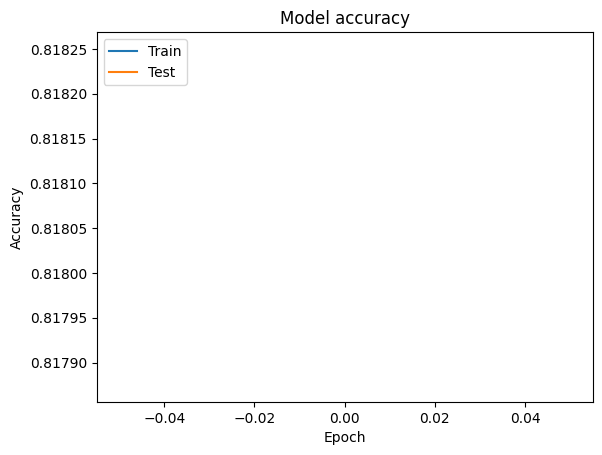

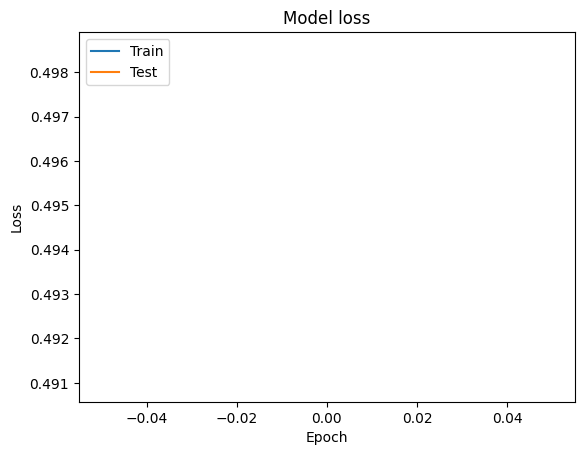

In [20]:
#Plotting the training accuracy from the history object with matplotlib
matplotlib.plot(history.history['accuracy'])
#is a list with all the accuracy values for the training set over each epoch
matplotlib.plot(history.history['val_accuracy'])
#Plotting the validation accuracy from the history object
matplotlib.title('Model accuracy')
# is a list with all the validation accuracy values over each epoch
matplotlib.ylabel('Accuracy')
#Give the title of the plot to indicate that it displays the model accuracy
matplotlib.xlabel('Epoch')
# Add a legend to the training and validation accuracy curves; 'Train' refers to training accuracy and 'Test' refers to validation accuracy
matplotlib.legend(['Train', 'Test'], loc='upper left')
# Display the plot with accuracy vs epochs
matplotlib.show()

# Plot the training loss from the history object with matplotlib
matplotlib.plot(history.history['loss'])
#is a list of loss values over each epoch for the train set
matplotlib.plot(history.history['val_loss'])
# Plot the validation loss from the history object
matplotlib.title('Model loss')
#is a list of the validation loss over each epoch
matplotlib.ylabel('Loss')
# Set the title of the plot to indicate that it's showing the model loss
matplotlib.xlabel('Epoch')
# Adds the legend to distinguish between the training and validation loss curves
matplotlib.legend(['Train', 'Test'], loc='upper left')
# it refers to the training loss curve and 'For Test, to the validation loss curve'
matplotlib.show()
# Renders the plot containing loss against epochs
